In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [209]:
import torch

if not torch.cuda.is_available():
    raise Exception('GPU not available.')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

SEED = 42
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f'Device: {torch.cuda.get_device_name(0)} | Seed: {SEED}' )

Device: NVIDIA GeForce GTX 1060 6GB | Seed: 42


In [210]:
import os

DATA_FOLDER = 'data'
SCRIPT_FOLDER = 'scripts'

archive_path = os.path.join(DATA_FOLDER, 'archive.zip')
CLOUD_TEST_PATH = os.path.join(DATA_FOLDER, '38-Cloud_test')
CLOUD_TRAIN_PATH = os.path.join(DATA_FOLDER, '38-Cloud_training')

# flag to check if archive.zip has already been unzipped
is_archive_unzipped = os.path.exists(CLOUD_TEST_PATH) and os.path.exists(CLOUD_TRAIN_PATH)

# raise error if archive.zip has not been found and it has not been unzipped yet
if not os.path.exists(archive_path) and not is_archive_unzipped:
    raise Exception('Error: archive.zip is missing from data folder')

print('Archive found. Unzipping...')

Archive found. Unzipping...


In [211]:
if (is_archive_unzipped == False):
    !unzip data/archive.zip -d data

In [212]:
if os.path.exists(archive_path) and is_archive_unzipped:
    !rm data/archive.zip

In [213]:
if not os.path.exists('data/38-Cloud_test/test_gt'):
    print('Building test gt...')
    !python3 scripts/build_test_gt.py
    

In [214]:
train_patches_name = 'training_patches_38-Cloud.csv'
test_patches_name = 'test_patches_38-Cloud.csv'

df_patches_train = pd.read_csv(os.path.join(CLOUD_TRAIN_PATH, train_patches_name))
df_patches_test = pd.read_csv(os.path.join(CLOUD_TEST_PATH, test_patches_name))
df_patches=pd.concat([df_patches_train,df_patches_test]).reset_index(drop=True)
df_patches.head()

,name
0,patch_1_1_by_1_LC08_L1TP_002053_20160520_20170...
1,patch_1_1_by_1_LC08_L1TP_002054_20160520_20170...
2,patch_1_1_by_1_LC08_L1TP_011002_20160620_20170...
3,patch_1_1_by_1_LC08_L1TP_011247_20160620_20170...
4,patch_1_1_by_1_LC08_L1TP_029040_20160720_20170...


In [215]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image

class Cloud38Dataset(Dataset):
    def __init__(self, patches_df, pytorch=True, test=False):
        super().__init__()

        self.test = test
        self.patches = [self.map_patches(f) for f in patches_df['name']]
        self.pytorch = pytorch        
        self.mean = None
        self.std = None

    def map_patches(self, file_name):  
        if self.test:
            train_path = Path(CLOUD_TEST_PATH)
            red_path = train_path / Path('test_red') / Path('red_' + file_name + '.TIF')
            green_path = train_path / Path('test_green') / Path('green_' + file_name + '.TIF')
            blue_path = train_path / Path('test_blue') / Path('blue_' + file_name + '.TIF')
            nir_path = train_path / Path('test_nir') / Path('nir_' + file_name + '.TIF')
            gt_path = train_path / Path('test_gt') / Path('gt_' + file_name + '.TIF')

        else:
            train_path = Path(CLOUD_TRAIN_PATH)
            red_path = train_path / Path('train_red') / Path('red_' + file_name + '.TIF')
            green_path = train_path / Path('train_green') / Path('green_' + file_name + '.TIF')
            blue_path = train_path / Path('train_blue') / Path('blue_' + file_name + '.TIF')
            nir_path = train_path / Path('train_nir') / Path('nir_' + file_name + '.TIF')
            gt_path = train_path / Path('train_gt') / Path('gt_' + file_name + '.TIF')

        return {
            'red' : red_path,
            'green' : green_path,
            'blue' : blue_path,
            'nir' : nir_path,
            'gt' : gt_path
        }   
    
    def __len__(self):
        return len(self.patches)

    def to_array(self, i, invert=False, include_nir=False):
        rgb = np.stack([
            np.array(Image.open(self.patches[i]['red'])),
            np.array(Image.open(self.patches[i]['green'])),
            np.array(Image.open(self.patches[i]['blue'])),
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.patches[i]['nir'])), axis=2)
            rgb = np.concatenate([rgb, nir], axis=2)

        if invert:
            rgb = rgb.transpose((2, 0, 1))
        
        return rgb / np.iinfo(rgb.dtype).max # images are uint16, so max is 65535
          
    
    def to_mask(self, i, add_dims=False):
        mask = np.array(Image.open(self.patches[i]['gt']))
        mask = np.where(mask == 255, 1, 0)

        if add_dims:
            return np.expand_dims(mask, 0)
        else:
            return mask
        
    def __getitem__(self, i):
        x = torch.tensor(self.to_array(i, invert=self.pytorch), dtype=torch.float32)
        y = torch.tensor(self.to_mask(i, add_dims=False), dtype=torch.float32)

        return x, y
        

In [216]:
data_train = Cloud38Dataset(df_patches_train)
print(f'Data has been loaded | Length: {len(data_train)}')

Data has been loaded | Length: 8400


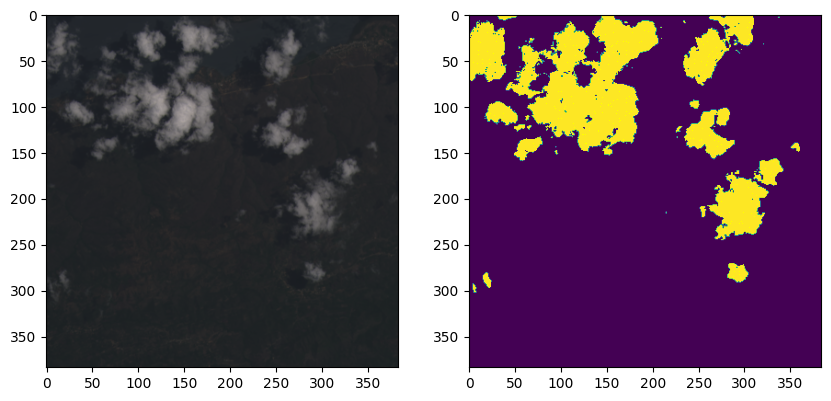

In [560]:
image_index = np.random.randint(0, len(data_train))

# we change the default colormap to make sure that 0 is purple and 1 is yellow
# even when the mask has only 0s or 1s
custom_cmap = plt.colormaps['viridis']
custom_cmap.set_under('purple')
custom_cmap.set_over('yellow')

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(data_train.to_array(image_index, include_nir=False))
ax[1].imshow(data_train.to_mask(image_index) , cmap=custom_cmap, vmin=0, vmax=1)


In [374]:
data_test_val = Cloud38Dataset(df_patches_test, test=True)
print(f'Data has been loaded | Length: {len(data_test_val)}')

Data has been loaded | Length: 9201


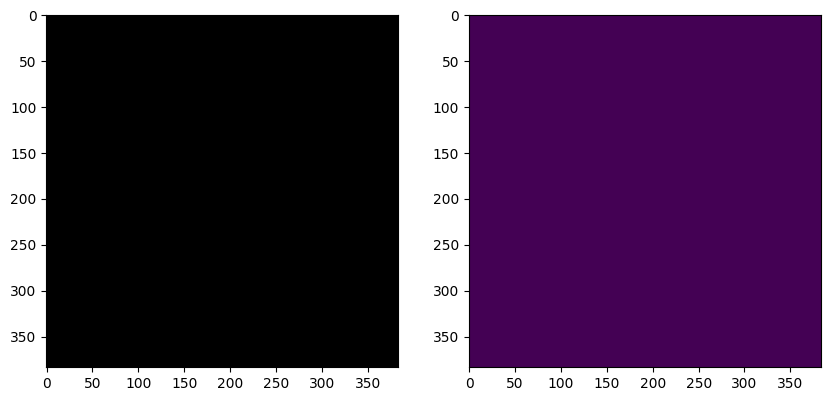

In [576]:

image_index = np.random.randint(0, len(data_test_val))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(data_test_val.to_array(image_index, include_nir=False))
ax[1].imshow(data_test_val.to_mask(image_index), cmap = custom_cmap, vmin=0, vmax=1)
#7892



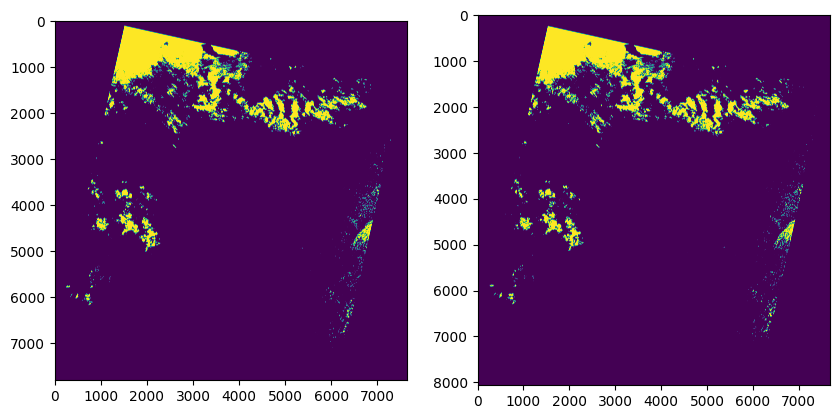

In [334]:
test_big = 'data/38-Cloud_test/Entire_scene_gts/edited_corrected_gts_LC08_L1TP_032035_20160420_20170223_01_T1.TIF'
test_big = np.array(Image.open(test_big))
#test_big = np.where(test_big == 255, 1, 0)

test_big_rec = 'test/LC08_L1TP_032035_20160420_20170223_01_T1.TIF'
test_big_rec = np.array(Image.open(test_big_rec))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(test_big)
ax[1].imshow(test_big_rec)
plt.show()


In [220]:
# rebuild full image from patches
# LC08_L1TP_003052_20160120_20170405_01_T1.TIF
print(df_patches['name'][0])
filter_df = df_patches[df_patches['name'].str.contains('LC08_L1TP_003052_20160120_20170405_01_T1')]
print(filter_df)

# now that we have the patches names in the dataframe we reconstruct the image
recon_size = len(filter_df)

patch_1_1_by_1_LC08_L1TP_002053_20160520_20170324_01_T1
                                                    name
8400   patch_1_1_by_1_LC08_L1TP_003052_20160120_20170...
8420   patch_10_1_by_10_LC08_L1TP_003052_20160120_201...
8450   patch_100_5_by_20_LC08_L1TP_003052_20160120_20...
8474   patch_101_6_by_1_LC08_L1TP_003052_20160120_201...
8494   patch_102_6_by_2_LC08_L1TP_003052_20160120_201...
...                                                  ...
17510  patch_95_5_by_15_LC08_L1TP_003052_20160120_201...
17530  patch_96_5_by_16_LC08_L1TP_003052_20160120_201...
17550  patch_97_5_by_17_LC08_L1TP_003052_20160120_201...
17571  patch_98_5_by_18_LC08_L1TP_003052_20160120_201...
17591  patch_99_5_by_19_LC08_L1TP_003052_20160120_201...

[420 rows x 1 columns]


In [221]:
from torch.utils.data import DataLoader
#import albumentations as A
#from albumentations.pytorch import ToTensorV2

IMAGE_SIZE = 384

loader_train = DataLoader(data_train, batch_size=32)
#print(loader_train)

pixel_sum = torch.tensor([0.0, 0.0, 0.0])
pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

for x, y in loader_train:
    pixel_sum += x.sum(axis=(0, 2, 3))
    pixel_sum_sq += (x ** 2).sum(axis=(0, 2, 3))

count = len(data_train) * IMAGE_SIZE * IMAGE_SIZE
mean = pixel_sum / count
var = (pixel_sum_sq / count) - (mean ** 2)
std = torch.sqrt(var)

print(f'Computed mean and std for the dataset:\n Mean: {mean} | Std: {std}')

KeyboardInterrupt: 

In [ ]:
# normalize the dataset using the mean and std computed above
data_train.mean = mean
data_train.std = std